# Generation of eQTL plots
Notebook for eQTL visualization as boxplots

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import scanpy as sc
import pandas as pd
import glob
from vcf import Reader
import matplotlib.pyplot as plt
import random

### Import anndata object
as generated by the <code>Notebook: count_processing_celltype_calling</code>

In [2]:
h5ad = '/Users/twanw/Documents/LUMC/projects/3UTRpancreas/RESULTS/ANALYSIS/3UTRpancreas.h5ad'
adata = sc.read_h5ad(h5ad)

### Import eQTLs
as generated by <code>eQTL_adjusted_pvalue.py</code>

In [3]:
file = '/Users/twanw/Documents/LUMC/projects/3UTRpancreas/Data_3UTR_project/3-eQTL/2-output_CSV/all-cells_allgroups.adjusted-pvalue.csv'
df = pd.read_csv(file, sep=',', names=['gene', 'variant','pvalue', 'type'])
df = df[df['pvalue'] < 0.05]
df['gene'] = df['gene'].apply(lambda x: x.rsplit('>')[0])

df = df.drop_duplicates()
df.head()

,gene,variant,pvalue,type
0,A1BG,19:58346865_GC_A1BG_,1.886468e-02,alpha-cells_healthy
3,A1BG,19:58346865_GC_A1BG_,4.173950e-08,alpha-cells_T2D
5,A1CF,10:50799874_A_A1CF_,3.891340e-02,alpha-cells_T2D
8,A1CF,10:50800083_T_A1CF_,3.365280e-02,alpha-cells_T2D
9,A1CF,10:50800797_G_A1CF_,3.365280e-02,alpha-cells_T2D


### Import VCF files
as generated by <code>VCF_filtering_annotation.sh</code>
Note: here split per chromosome, to run the code faster

In [4]:
# vcf files
vcf_files = '/Users/twanw/Documents/LUMC/projects/3UTRpancreas/Data_3UTR_project/2-variants/1-VCF/smartseqPancreas_3UTR_gene_annotated_chr*.vcf'

VCFfiles = glob.glob(vcf_files)
chromosomes = [i.rsplit("chr")[1].rsplit(".vcf")[0] for i in VCFfiles]
vcf_dict = {}
for i,chr in enumerate(chromosomes):
    vcf_dict[chr] = VCFfiles[i]

### Functions
Functions to read, process, and plot the data

In [5]:
def get_genotypes(adata, vcf, variant, group='all'):
    """Extract the allele sequences for a specific genetic variant from a 
    variant call format file and make a boxplot from this variant """    
    # import VCF file
    VCF = Reader(fsock=None, filename=vcf, prepend_chr=False, strict_whitespace=False, encoding='ascii')
    
    # filter adata for group
    
    if group == 'all':
        adatax = adata
    else:
        adatax = adata[(adata.obs['Group'] == group)]
        
    donor_list = list(set(adatax.obs['Donor'])) # list of donors to select which genotype to use in plot
   
    # read VCF file
    genotype_dict = {}
    for ii, record in enumerate(VCF):
        rec = str(record)
        varname = str(rec.rsplit("CHROM=")[1].rsplit(",")[0] + ":"
                  + rec.rsplit("POS=")[1].rsplit(",")[0]) # varname = chr:position
        if varname in variant:
            ref = str(rec.rsplit("REF=")[1].rsplit(",")[0]) # get the reference sequence
            alts = str(rec.rsplit('ALT=[')[1].rsplit("]")[0]) # get the alternative sequences
            alts = alts.rsplit(',') 
            allels = [ref] + [i.strip() for i in alts] # append the ref and alt sequences in 1 list
            for sample in record.samples: # loop over the genotype results for given variant
                s = str(sample)
                donor = str(s.rsplit("sample=")[1].rsplit(",")[0]) # get donor name
                #print(donor)
                if donor in donor_list:
                    GT = str(s.rsplit("GT=")[1].rsplit(",")[0]) # e.g. GT=1/1
                    GT = GT.replace('|','/')
                    try: # skip if genotype contains '.' (e.g. not called)
                        al1 = int(GT.rsplit('/')[0])
                        al2 = int(GT.rsplit('/')[1])
                    except:
                        continue

                    if al1 == 0 and al2 == 0:
                        gtype = '0-Homozygous REF'
                    elif al1 == 0 and al2 > 0:
                        gtype = '1-Heterozygous'
                    else:
                        gtype = '2-Homozygous ALT'

                    genotype_dict[donor] = []
                    genotype_dict[donor].append(str(allels[al1] + "/" + allels[al2])) # append variant sequences to dict
                    genotype_dict[donor].append(str(gtype + '-' + str(al2)))# append donor genotype to dict
            break
    return genotype_dict

def get_adata_sub(adata, geno, celltype, group):
    adata_sub = adata[adata.obs['Donor'].isin(list(geno.keys()))].copy()
    adata_sub = adata_sub[adata_sub.obs['Cell_type'] == celltype].copy()
    adata_sub = adata_sub[adata_sub.obs['Group'] == group].copy()
    adata_sub.obs['genotype'] = adata_sub.obs['Donor'].apply(lambda x: geno[x][1])
    adata_sub.obs['alleles'] = adata_sub.obs['Donor'].apply(lambda x: geno[x][0])
    
    return adata_sub

def get_matrix(adata):
    matrix = pd.DataFrame(adata.raw.X, columns=adata.raw.var.index, index=adata.obs.index)
    return matrix

def get_data(genotypes, adata, gene):
    
    matrix = get_matrix(adata)
    
    data = []
    gt = sorted(set([genotypes[cell][1] for cell in genotypes]))
    for g in gt:
        cell_index = adata.obs[adata.obs['genotype'] == g].index
        matrix_list = list(matrix.loc[cell_index, gene])
        data.append(matrix_list)
        
    return data

def onecelltype_boxplot(data1, genotypes, color_rgb, title='rs0001', ylabel='gene X', fontsize=10):    
    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['xtick.labelsize'] = fontsize
    plt.rcParams['ytick.labelsize'] = fontsize
    plt.rcParams['figure.titlesize'] = fontsize
    plt.rcParams['font.size'] = fontsize
     
    ''' data1 = [REF, HET, ALT]
    genotypes = ['T/T', 'T/C', 'C/C']'''
    
    fig, ax = plt.subplots(dpi=300, figsize=(2,3))

    x = range(len(genotypes))
    delta = 0
    position1 = [xi-delta for xi in x]

    def individual_points(data, position):
        xs = []
        ys = []
        for d, x in zip(data, position):
            scatter = [random.uniform(x-0.07, x+0.07) for i in range(len(d))]
            xs += scatter
            ys += list(d)
        return xs,ys
    
    def rgb_to_rgba(rgb, alpha=1.0):
        return tuple([channel / 255.0 for channel in rgb] + [alpha])
    
    x,y = individual_points(data1, position1)
    ax.scatter(x, y, s=1, color='black', zorder=10)

    ax.boxplot(data1, 
               positions = position1, 
               showcaps=False, 
               patch_artist=True, 
               boxprops=dict(facecolor=rgb_to_rgba(color_rgb, alpha=1.0), color='black'),
               medianprops=dict(color='black'),
               showfliers=False
              );

    ax.set_xticks(range(len(genotypes)))
    ax.set_xticklabels(genotypes, rotation=45)
    ax.set_title(title.replace('healthy', 'ND'))
    ax.set_ylabel(ylabel)
    ax.grid(False)
    
    return ax
    
def twocelltype_boxplot(data1, data2, genotypes, color1_rgb, color2_rgb, alpha1, alpha2, title='rs0001', ylabel='gene X', fontsize=10):
    ''' data1 = [REF, HET, ALT]
    genotypes = ['T/T', 'T/C', 'C/C']'''

    plt.rcParams['axes.titlesize'] = fontsize
    plt.rcParams['axes.labelsize'] = fontsize
    plt.rcParams['xtick.labelsize'] = fontsize
    plt.rcParams['ytick.labelsize'] = fontsize
    plt.rcParams['figure.titlesize'] = fontsize
    plt.rcParams['font.size'] = fontsize
    
    fig, ax = plt.subplots(dpi=300, figsize=(2,3))

    x = range(len(genotypes))
    delta = 0.18
    position1 = [xi-delta for xi in x]
    position2 = [xi+delta for xi in x]

    def individual_points(data, position):
        xs = []
        ys = []
        for d, x in zip(data, position):
            scatter = [random.uniform(x-0.07, x+0.07) for i in range(len(d))]
            xs += scatter
            ys += list(d)
        return xs,ys

    def rgb_to_rgba(rgb, alpha=1.0):
        return tuple([channel / 255.0 for channel in rgb] + [alpha])

    x,y = individual_points(data1, position1)
    ax.scatter(x, y, s=1, color='black', zorder=10)

    x,y = individual_points(data2, position2)
    ax.scatter(x, y, s=1, color='black', zorder=10)

    ax.boxplot(data1, 
               positions = position1, 
               showcaps=False, 
               patch_artist=True, 
               boxprops=dict(facecolor=rgb_to_rgba(color1_rgb, alpha=alpha1), color='black'),
               medianprops=dict(color='black'),
               showfliers=False
              );

    ax.boxplot(data2, 
               positions = position2, 
               showcaps=False, 
               patch_artist=True, 
               boxprops=dict(facecolor=rgb_to_rgba(color2_rgb, alpha=alpha2), color='black'),
               medianprops=dict(color='black'),
               showfliers=False
              );

    ax.set_xticks(range(len(genotypes)))
    ax.set_xticklabels(genotypes, rotation=45)
    ax.set_title(title.replace('healthy', 'ND'))
    ax.set_ylabel(ylabel)
    ax.grid(False)
    
    return ax
    
def hex_to_rgb(hexa):
    return tuple(int(hexa[i:i+2], 16)  for i in (0, 2, 4))
    
def plot(gene, chromosome, variant, celltype, group, color, set_ylim=False, ylim=(0,6), include_allgroups=False, fontsize=10):
    genotypes = get_genotypes(adata, vcf_dict[chromosome], variant, group='all')
    adata_sub = get_adata_sub(adata, genotypes, celltype, group)
    alleles = {genotypes[cell][1]:genotypes[cell][0] for cell in genotypes}    

    data = get_data(genotypes, adata_sub, gene)
    
    alleles_list = [alleles[geno] for geno in sorted(alleles)]
        
    if include_allgroups:
        adata_sub1 = get_adata_sub(adata, genotypes, celltype, 'healthy')
        adata_sub2 = get_adata_sub(adata, genotypes, celltype, 'T2D')

        data1 = get_data(genotypes, adata_sub1, gene)
        data2 = get_data(genotypes, adata_sub2, gene)
        
        ax = twocelltype_boxplot(data1, data2, alleles_list, color, color, 1, 0.5, title=f'{variant}\n{celltype}', ylabel=f'{gene} expression', fontsize=fontsize)
    
    else:
        ax = onecelltype_boxplot(data, alleles_list, color, title=f'{variant}\n{celltype} {group}', ylabel=f'{gene} expression', fontsize=fontsize)

    if set_ylim:
        ax.set_ylim(ylim)


### Plot the data

In [6]:
genes = ['PDX1', 'PCSK2', 'UNC5B', 'MEIS2', 'GP2', 'KRT80', 'NOTCH3', 'ANGPT2', 'THAP5', 
         'PABPC1', 'ATP6V1C1', 'TLK1', 'TNRC6B', 'LSM4', 'SLC30A8', 'SLC30A8', 'SLC30A8', 'SLC30A8', 'GRN', 
         'GRN', 'GRN', 'GRN', 'GRN', 'GRN', 'PTEN', 'PTEN', 'SNX27', 'SNX27']
variants = ['13:27926043', '20:17484568', '10:71299601', '15:36891245', 
            '16:20310145', '12:52170498', '19:15159772', '8:6500465', '7:108562481', '8:100697310', 
            '8:103069768', '2:170993691', '22:40335773', '19:18306344', '8:117173494', '8:117173494', 
            '8:117172786', '8:117172786', '17:44352876', '17:44352876', '17:44352876', '17:44352876', 
            '17:44352876', '17:44352876', '10:87966988', '10:87966988', '1:151698114', '1:151698114']
celltypes = [ 'beta-cells', 'alpha-cells', 'delta-cells', 'PP-cells', 'acinar-cells',
             'ductal-cells', 'stellate-cells', 'endothelial-cells', 'beta-cells', 'beta-cells', 'beta-cells', 
             'alpha-cells', 'alpha-cells', 'alpha-cells', 'beta-cells', 'alpha-cells', 'beta-cells', 
             'alpha-cells', 'alpha-cells', 'alpha-cells', 'acinar-cells', 'ductal-cells', 'ductal-cells', 
             'stellate-cells', 'beta-cells', 'beta-cells', 'beta-cells', 'beta-cells']
groups = ['healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
          'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy', 'healthy',
          'healthy', 'healthy', 'healthy', 'T2D', 'healthy', 'healthy', 'T2D', 'healthy', 'healthy', 'T2D',
          'healthy', 'T2D']
include_all_groups = [False, False, False, False, False, False, False, False, True, True,
                      True, True, True, True, False, False, False, False, False, False, False, False, False,
                      False, False, False, False, False]

chromosomes = [v.split(':')[0] for v in variants]

colors_cells = {'acinar-cells': '#1f77b4', 
                'ductal-cells':'#ff7f0e', 
                'endothelial-cells':'#279e68', 
                'PP-cells':'#d62728',
                'stellate-cells': '#aa40fc', 
                'alpha-cells':'#8c564b', 
                'beta-cells':'#e377c2', 
                'delta-cells':'#b5bd61'}

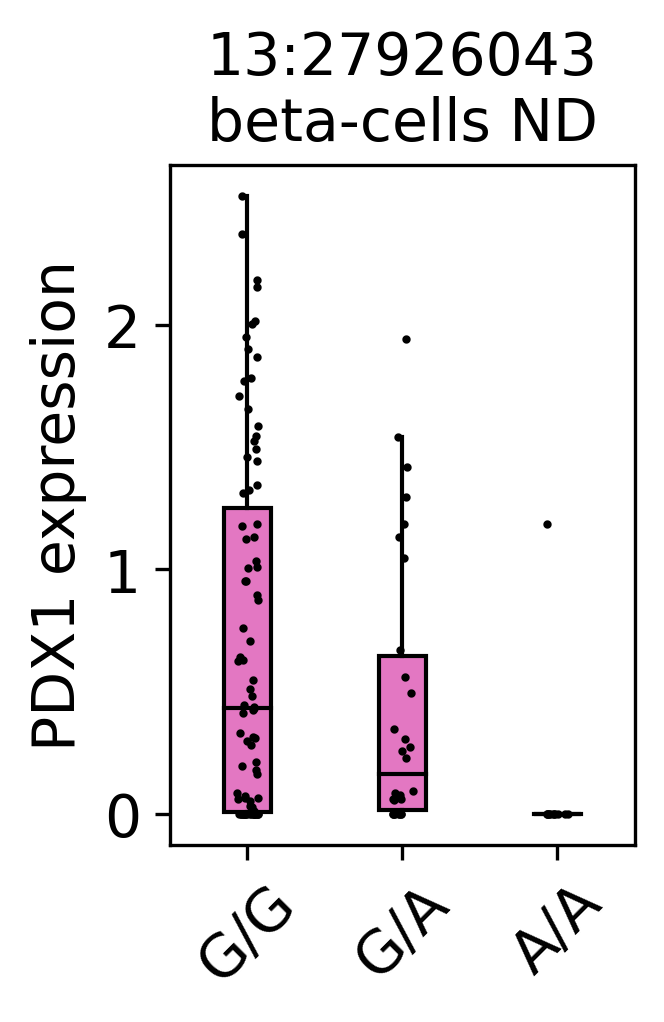

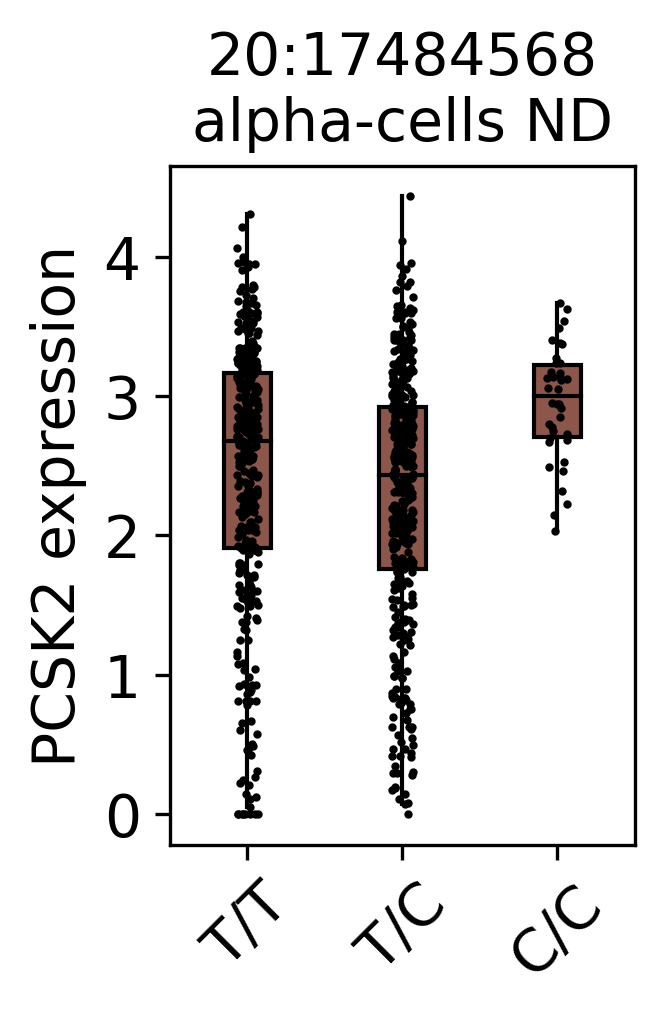

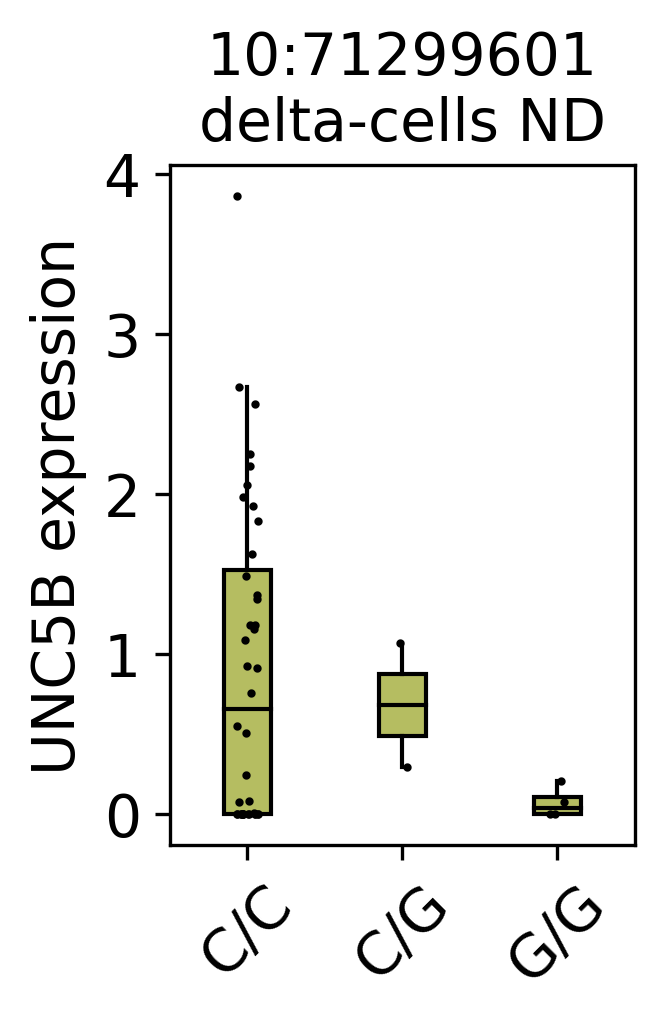

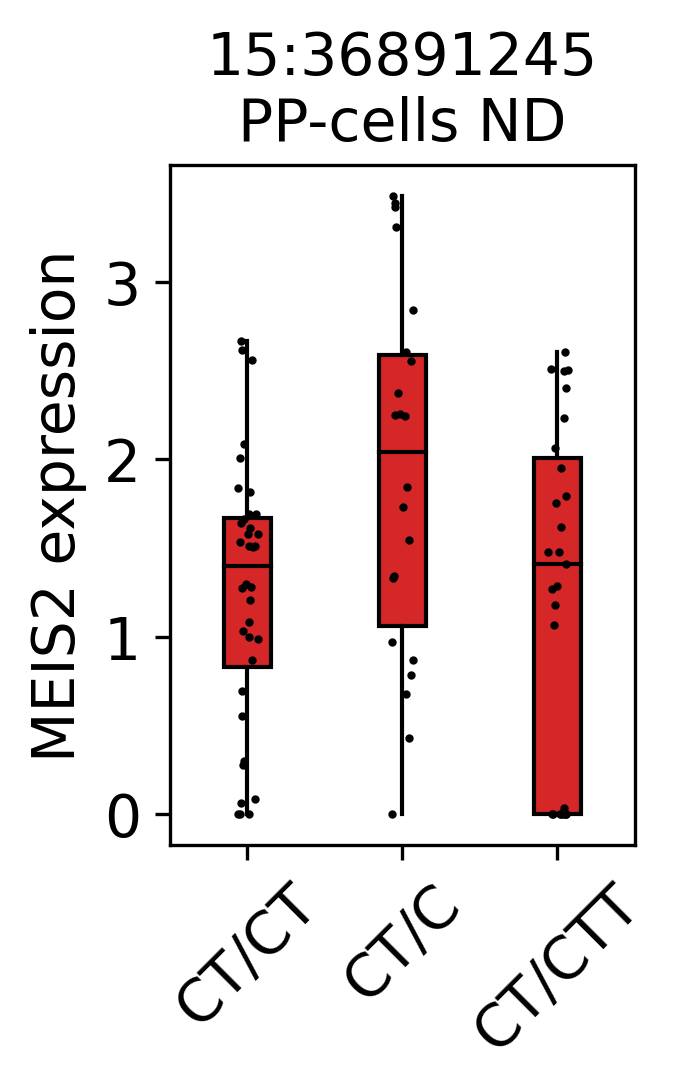

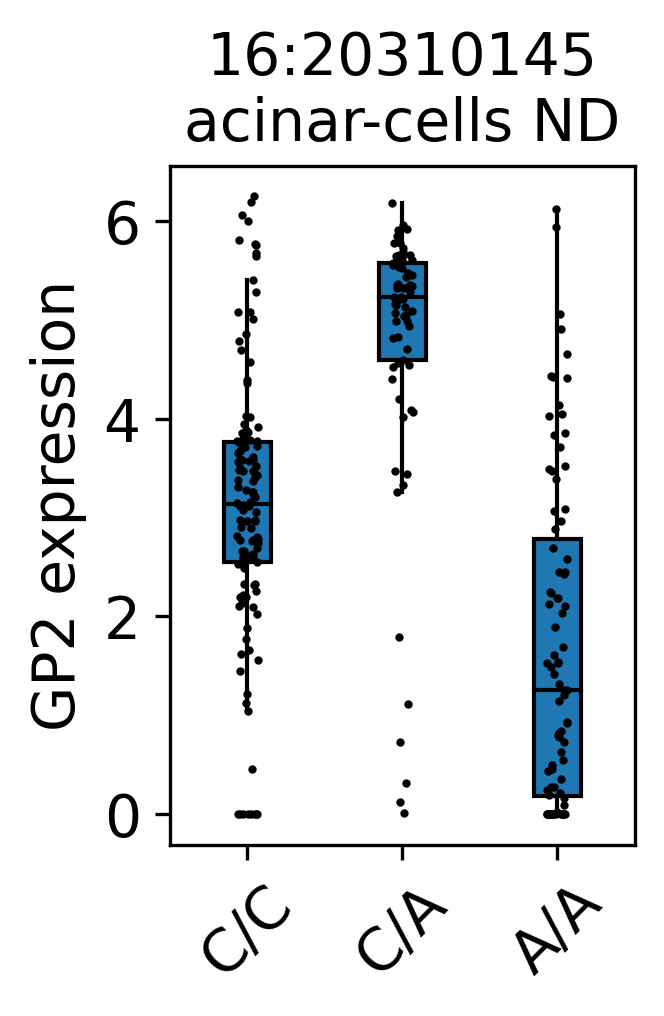

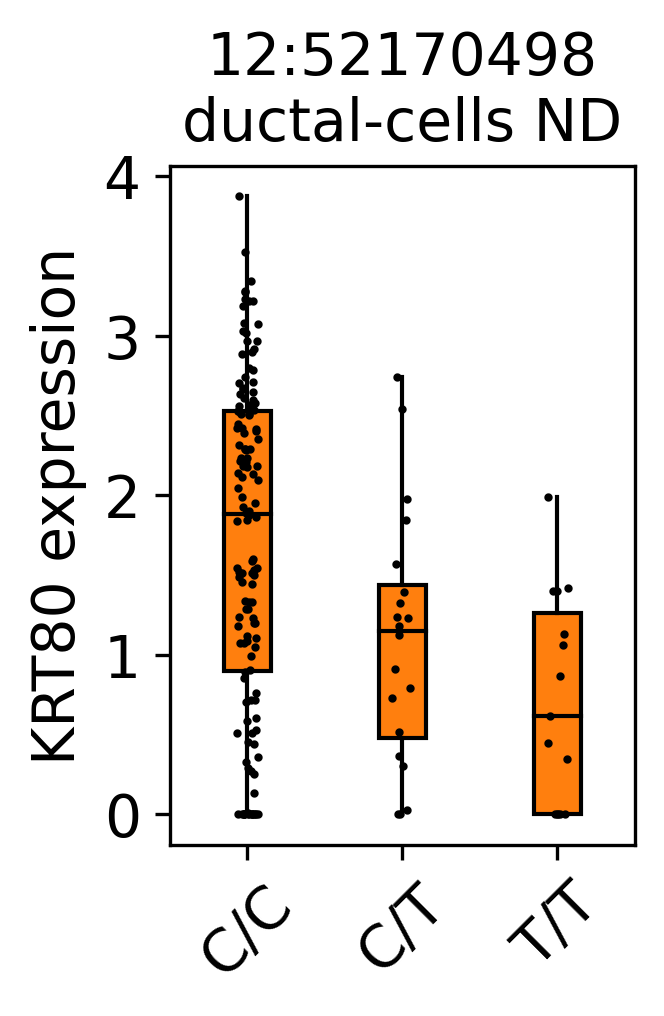

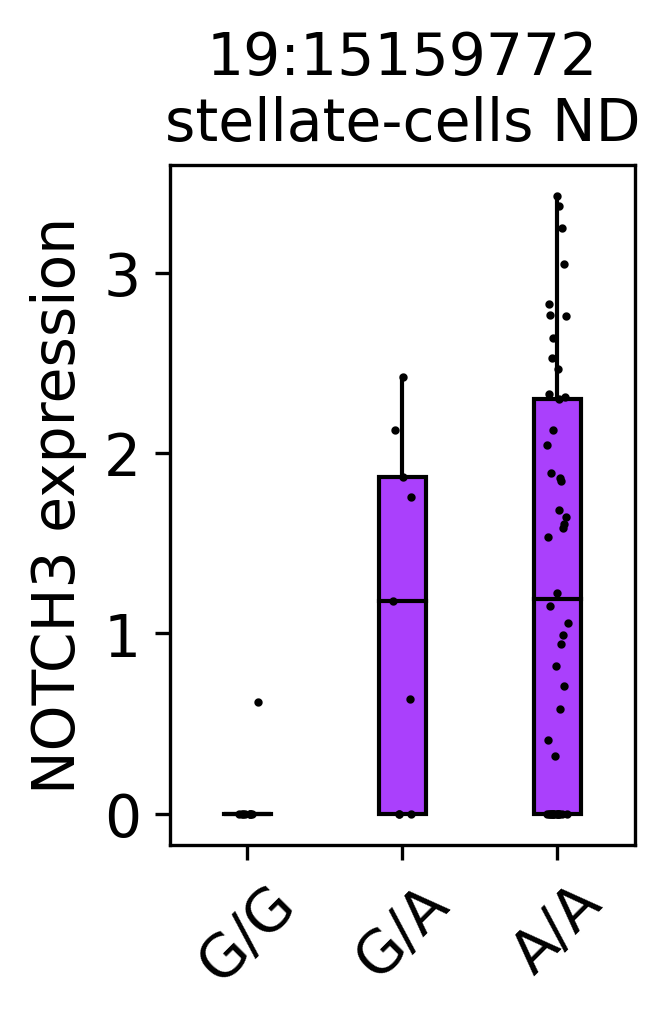

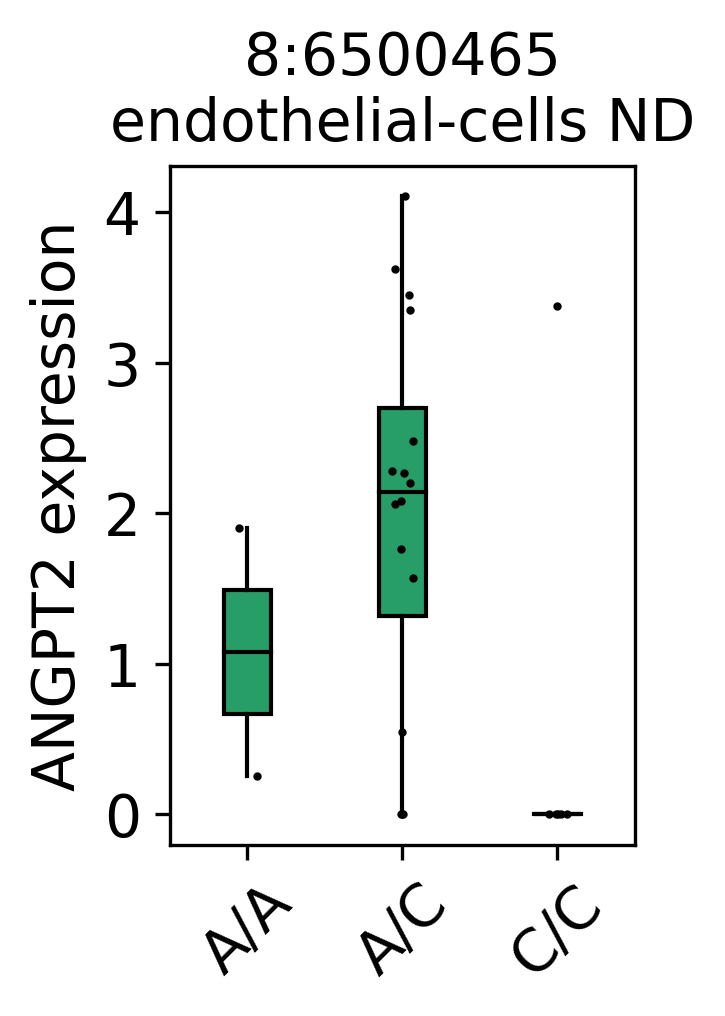

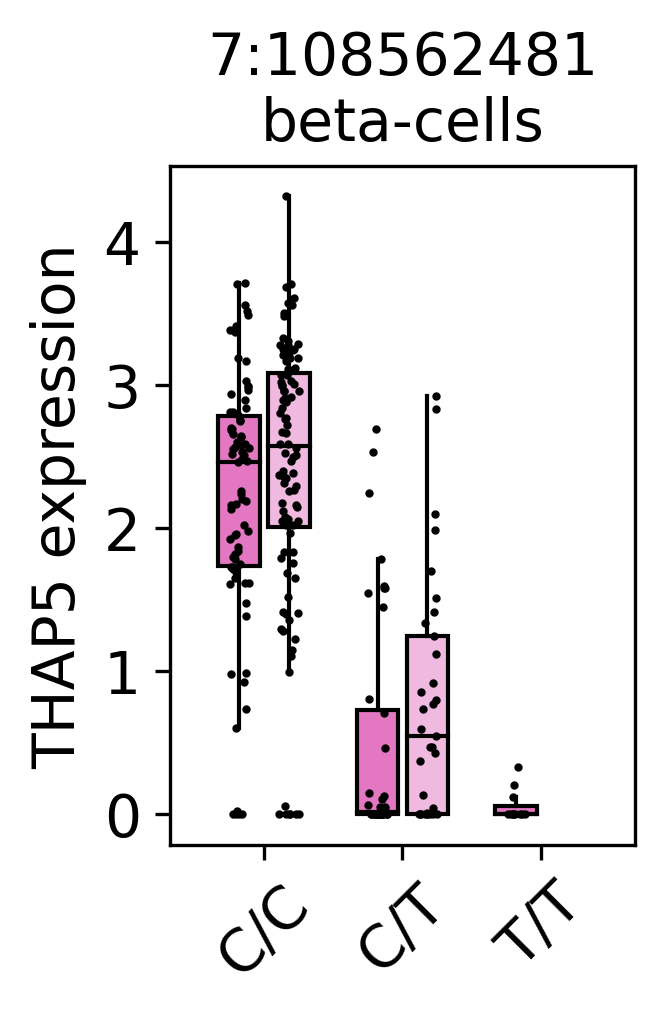

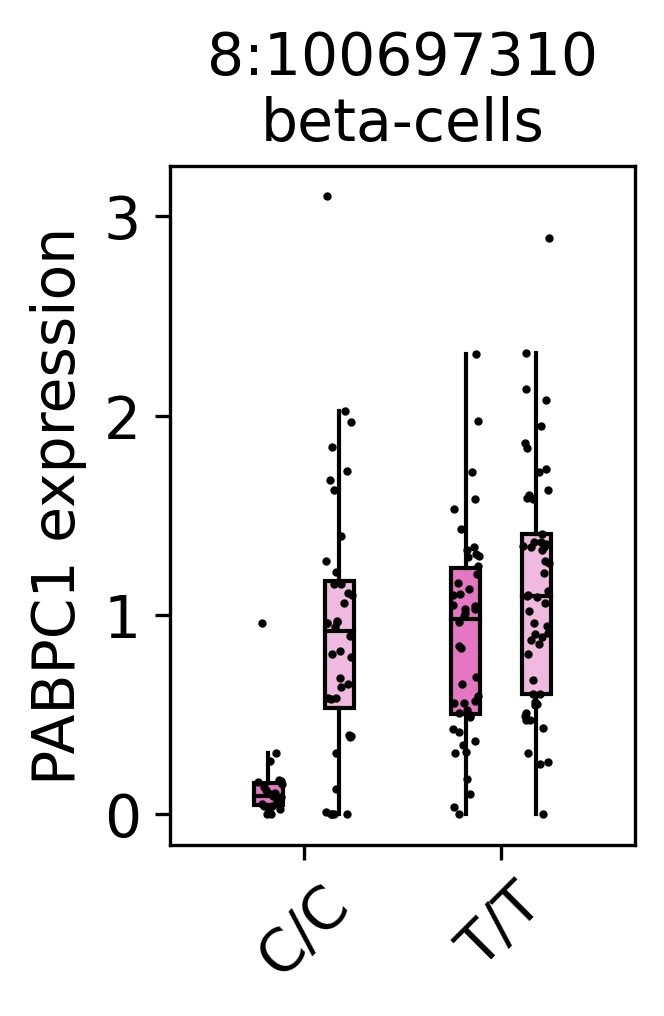

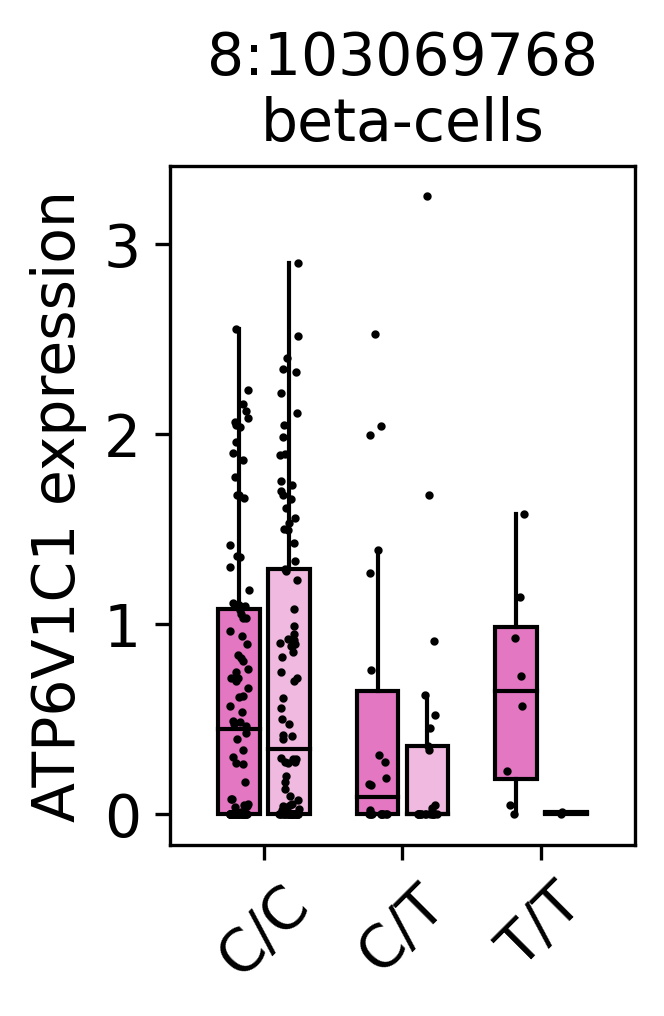

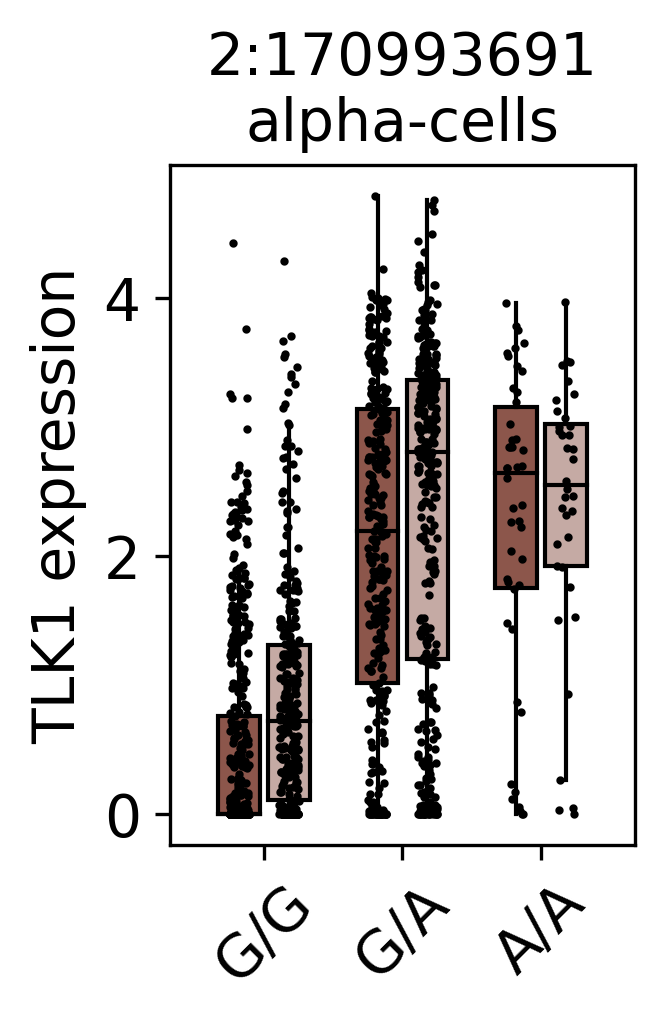

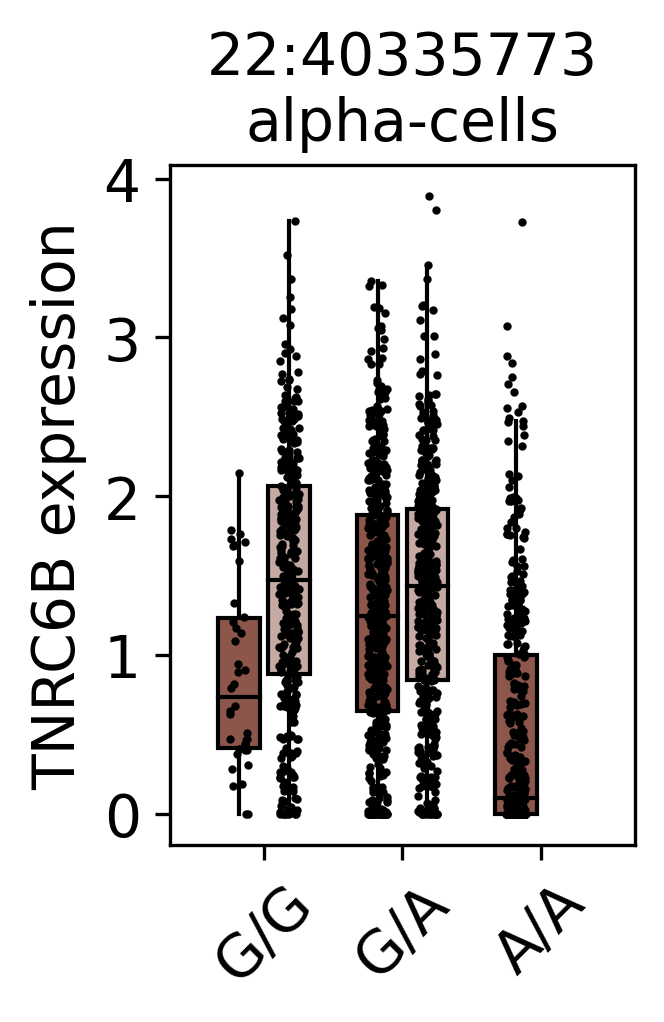

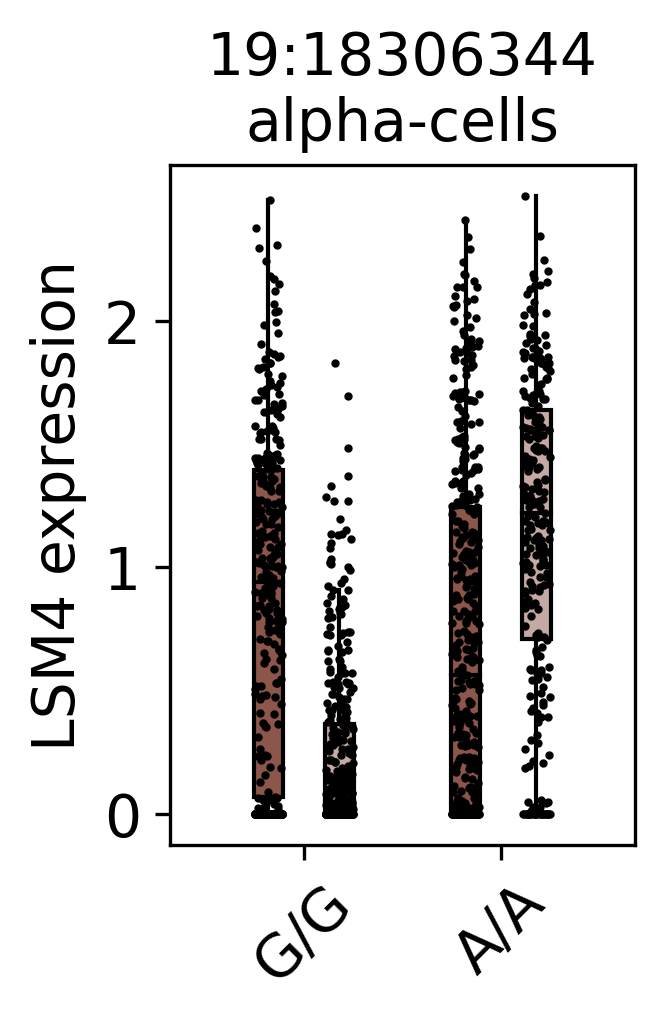

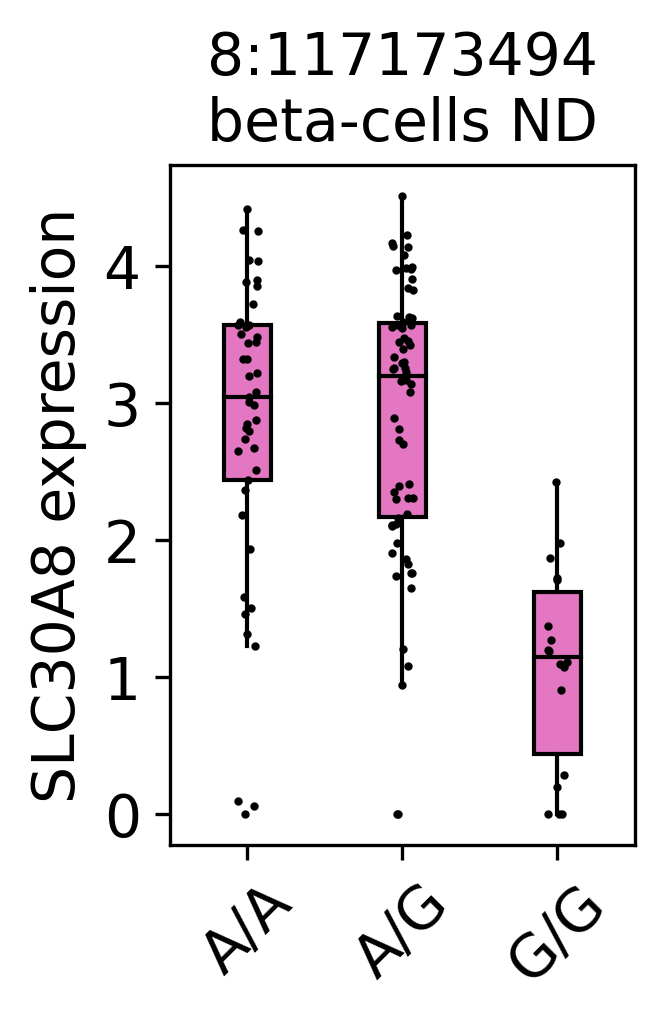

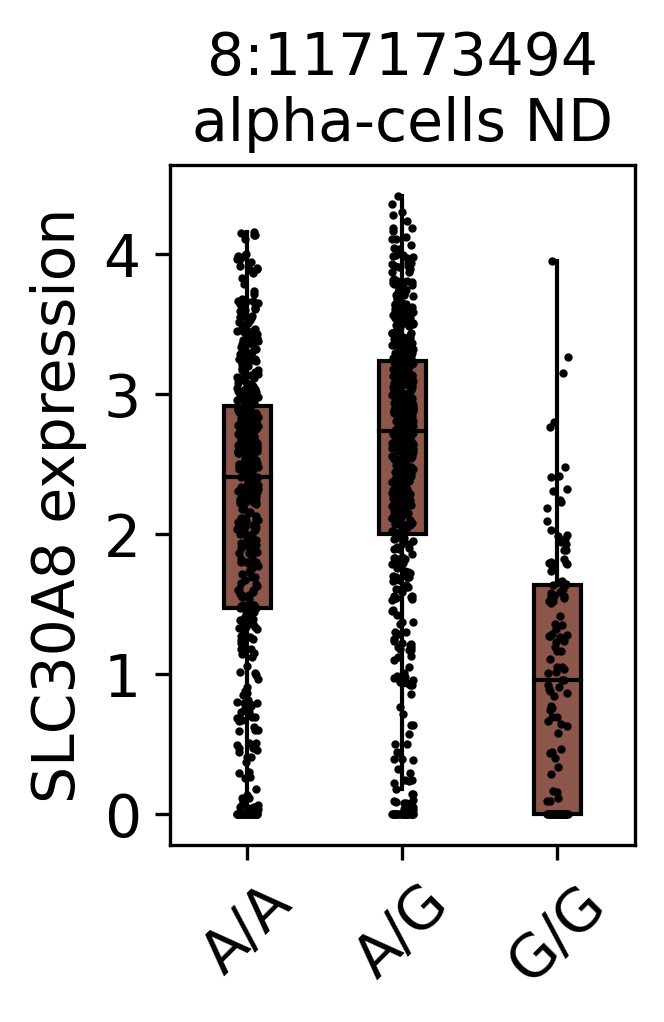

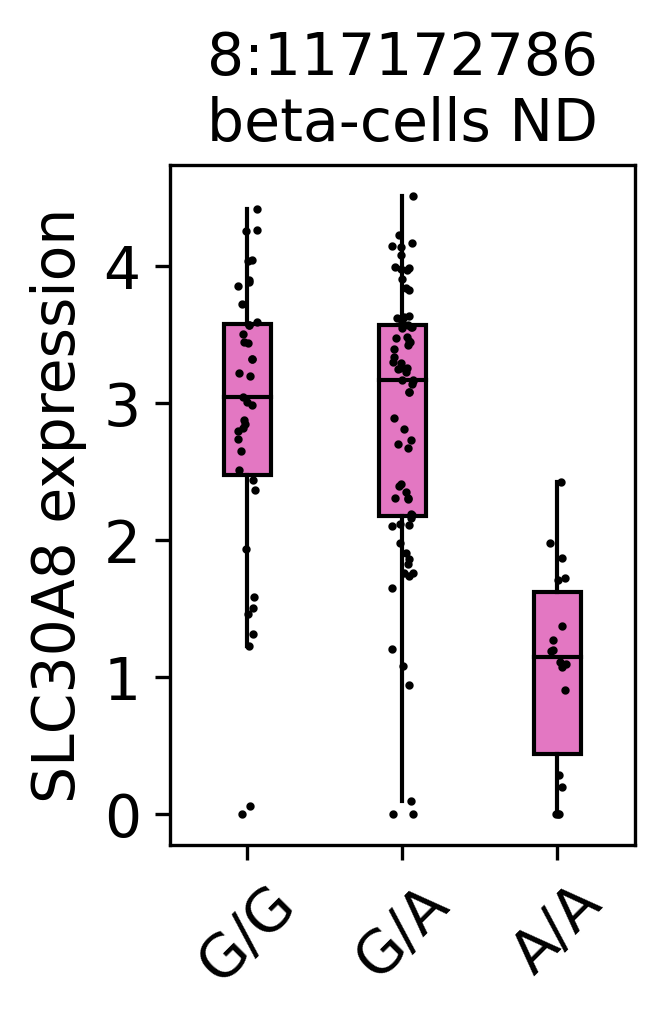

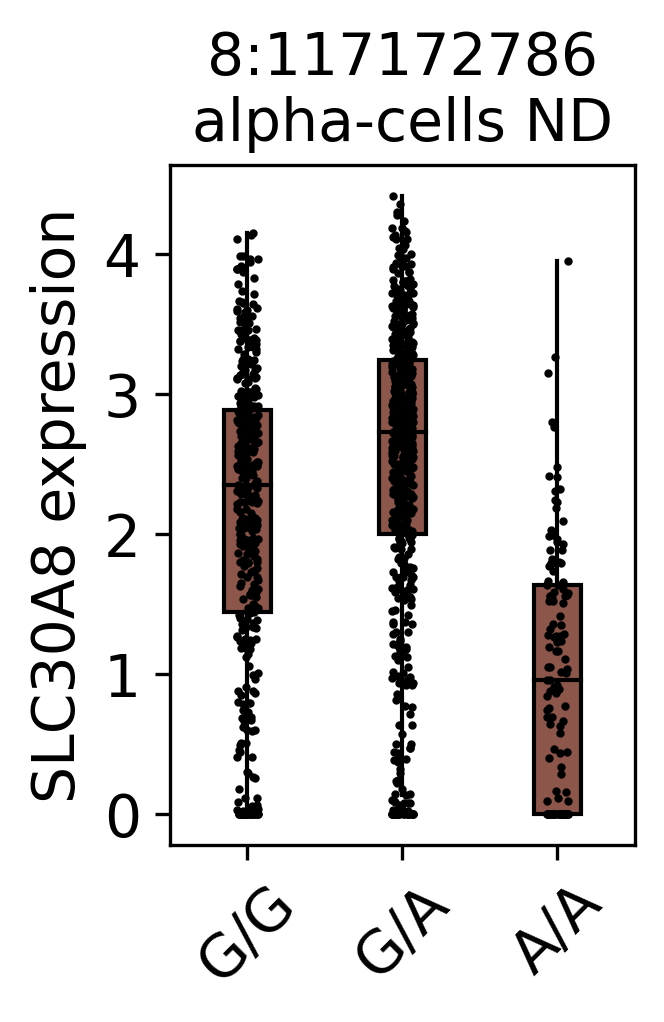

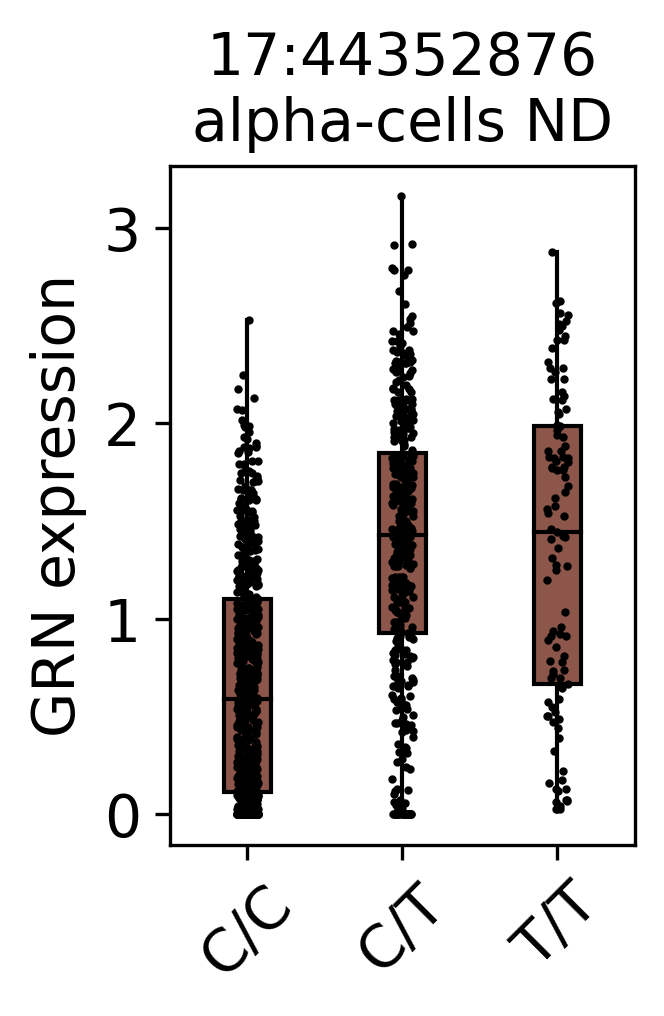

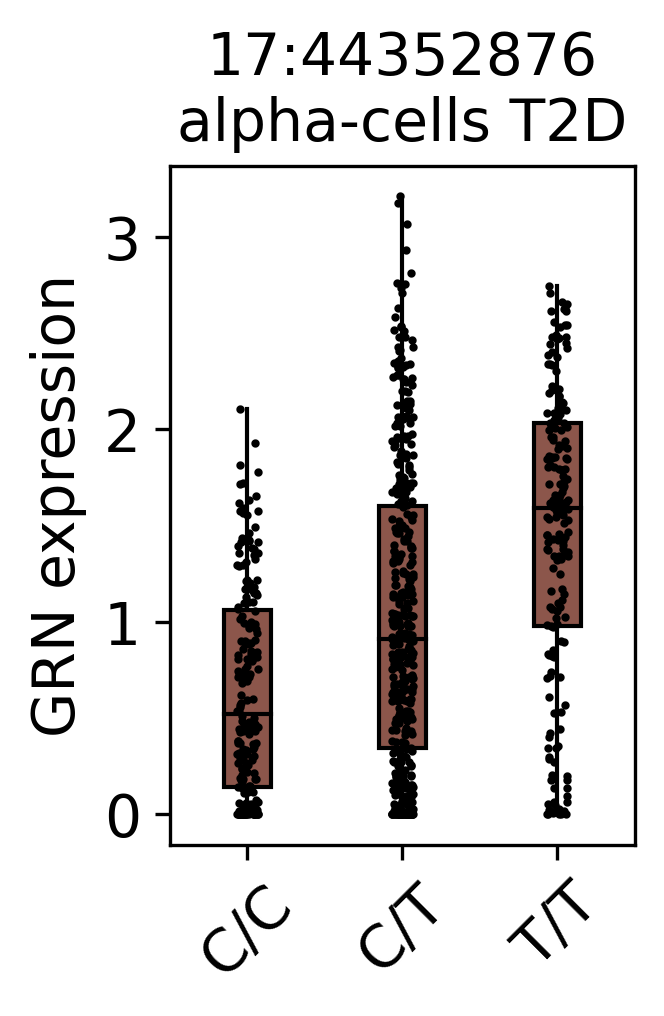

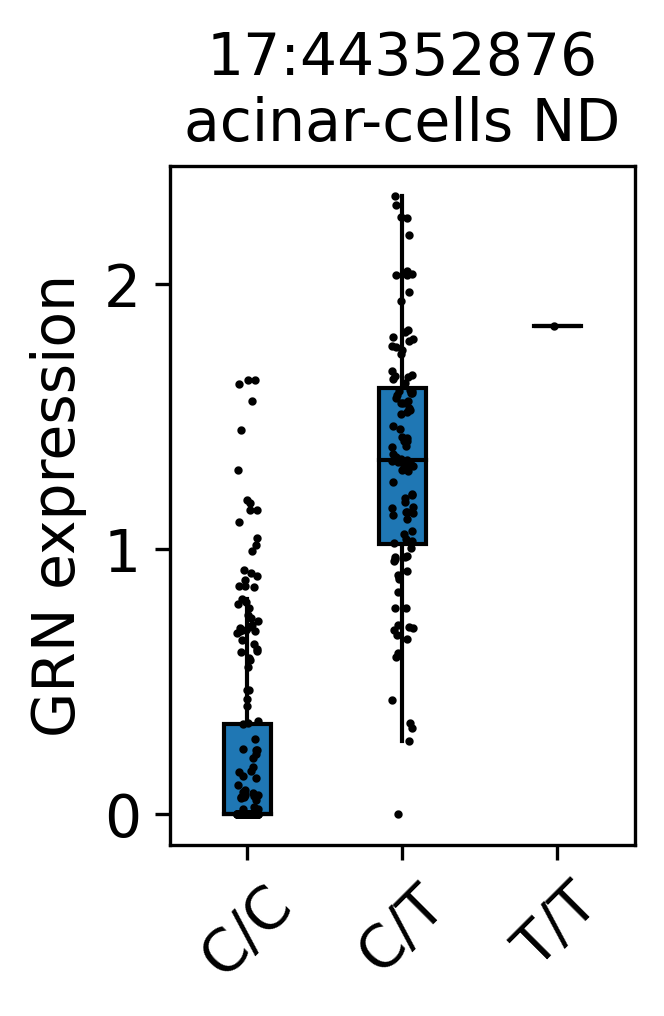

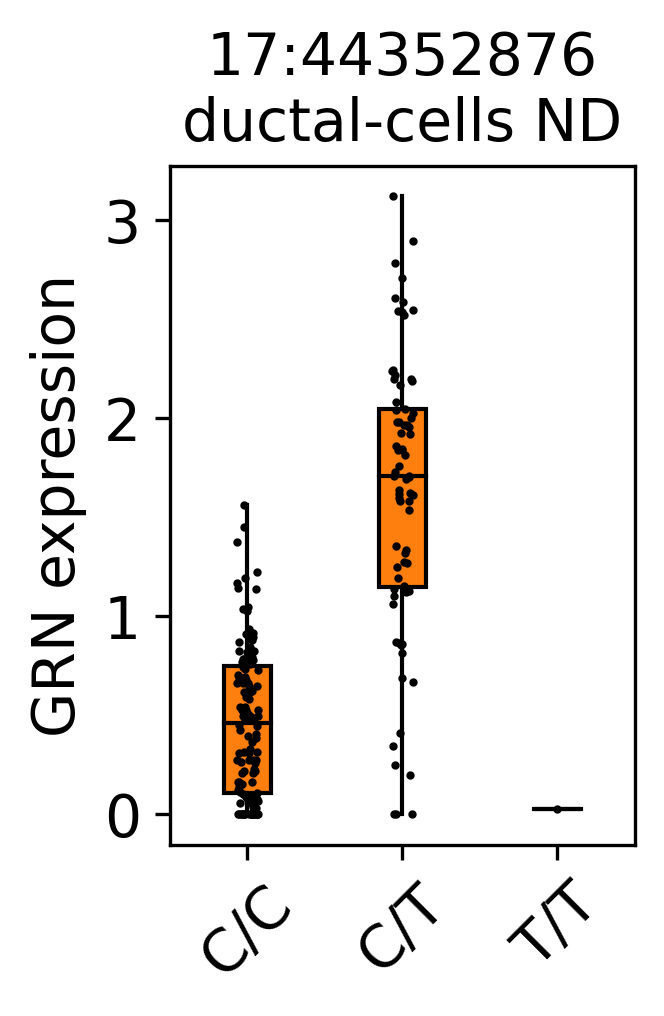

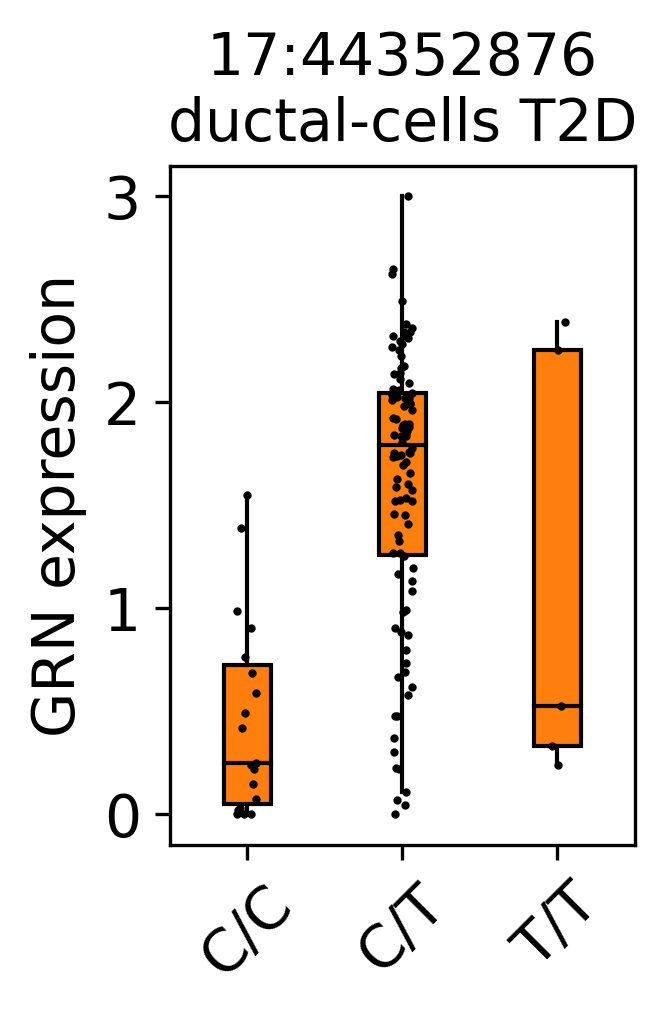

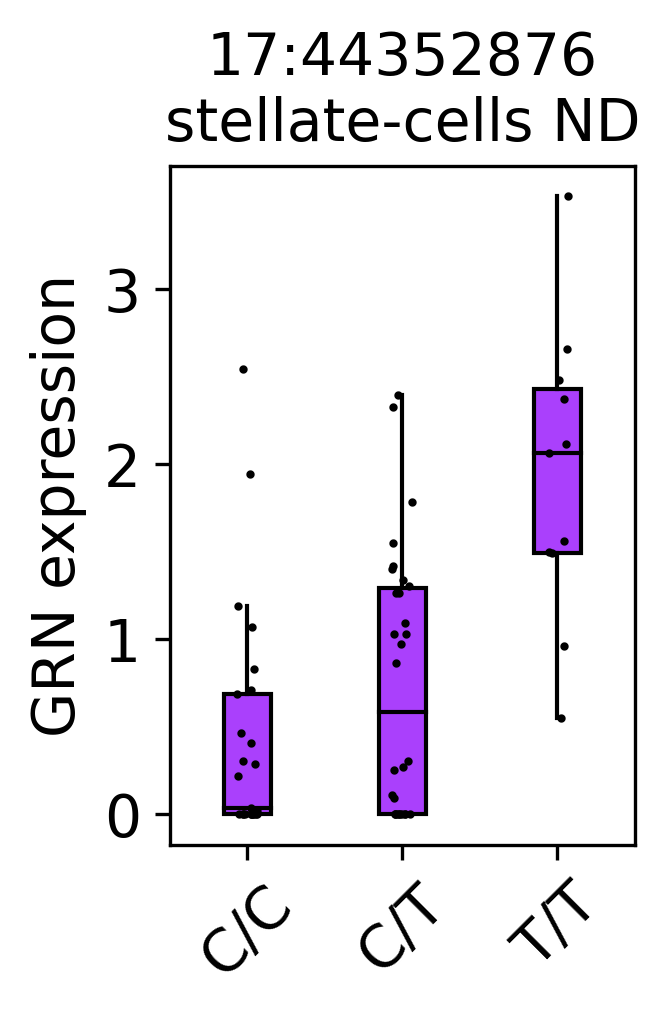

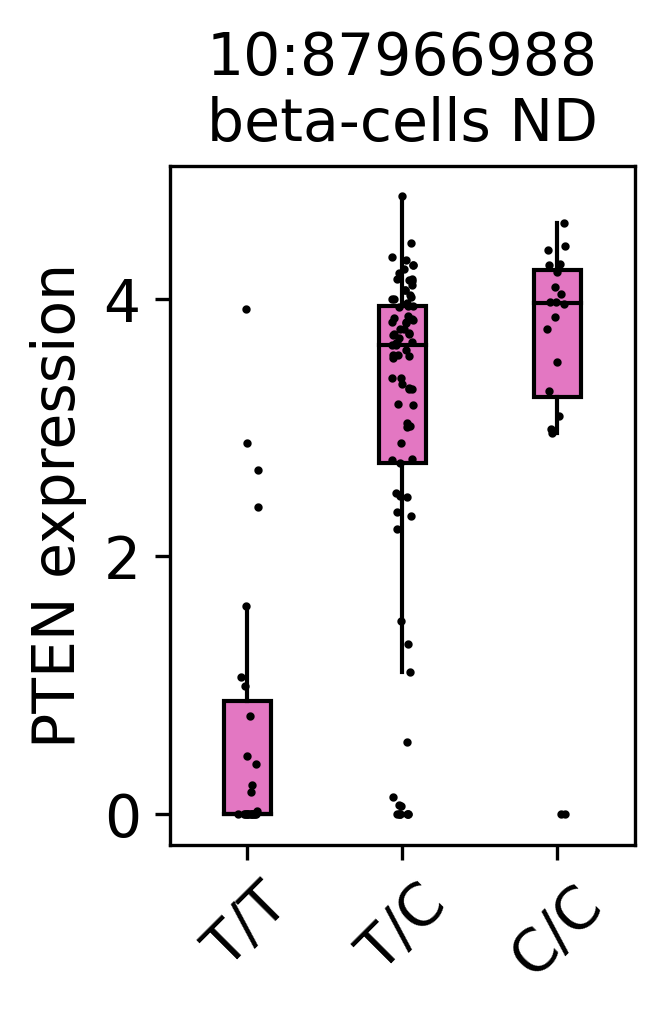

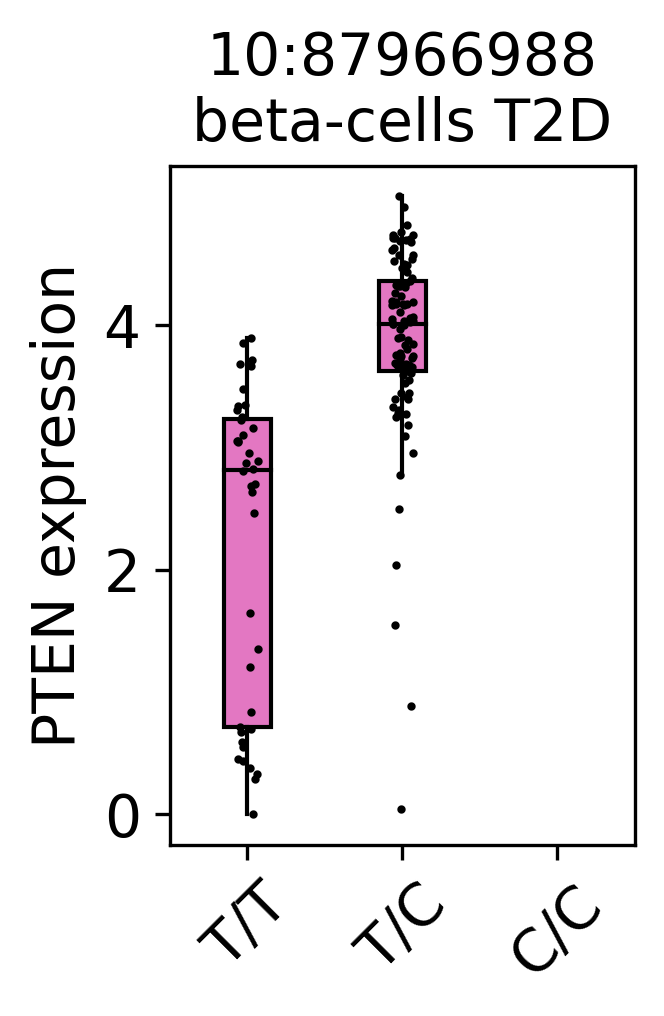

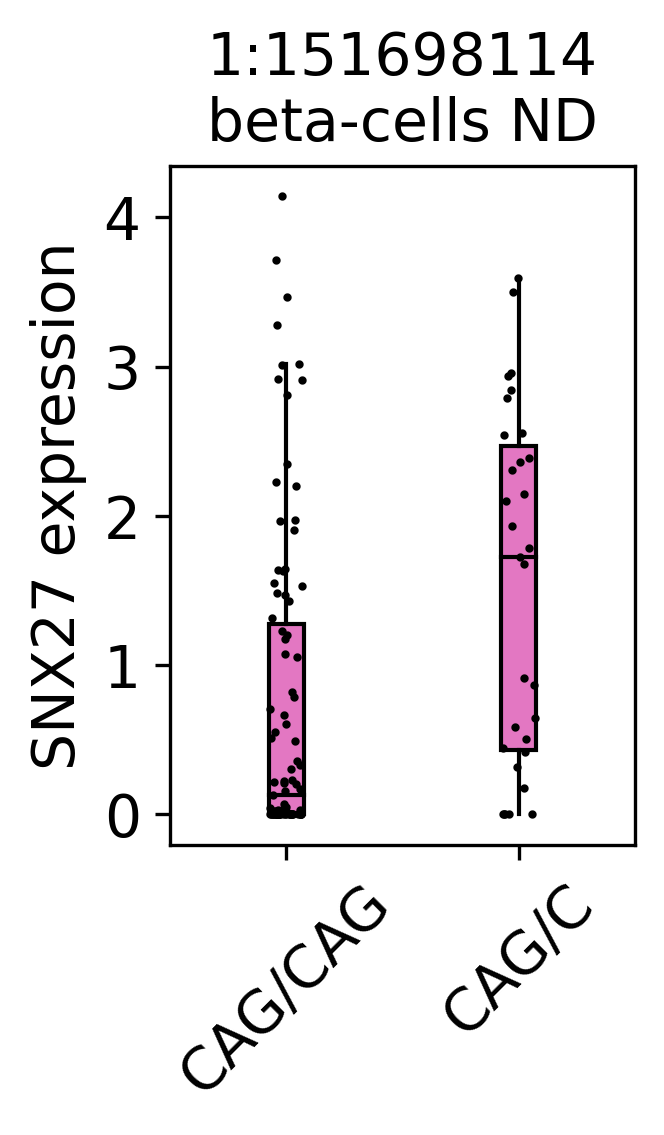

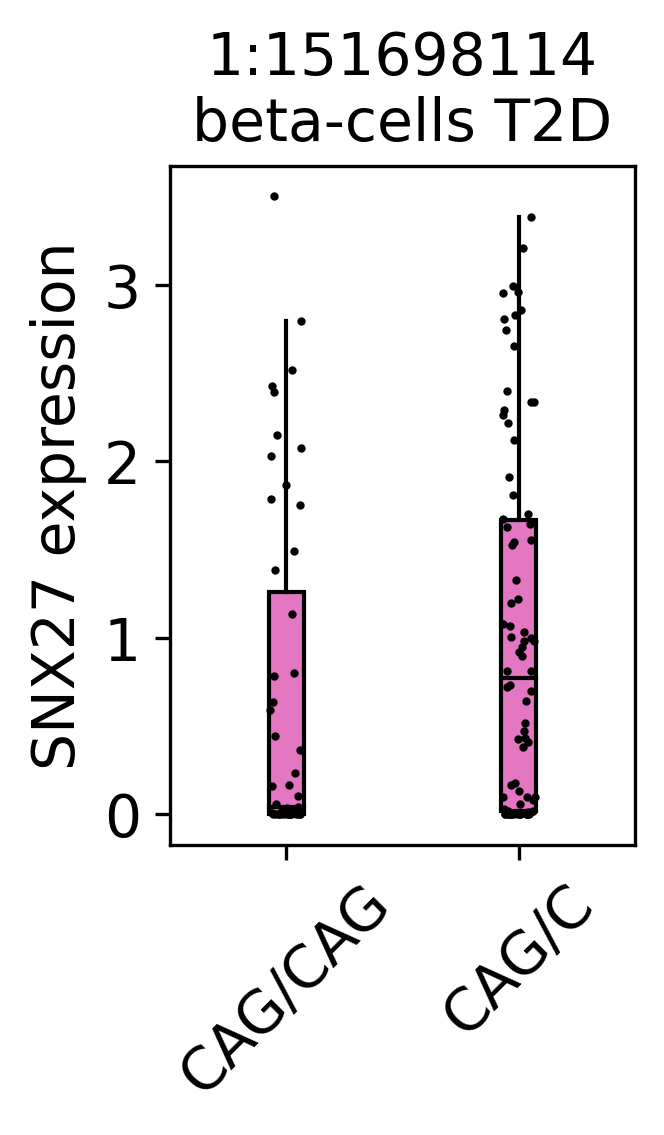

In [7]:
for gene, chromosome, variant, celltype, group, inc_groups in zip(genes, chromosomes, variants, celltypes, groups, include_all_groups): 
    plot(gene, 
         chromosome, 
         variant, 
         celltype, 
         group, 
         hex_to_rgb(colors_cells[celltype].strip('#')), 
         fontsize=14, 
         set_ylim=False,
         include_allgroups=inc_groups)
